<a href="https://colab.research.google.com/github/kojiyam/denso/blob/master/denso07_2_interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 送信局・干渉・単一のシミュレーション

[Q] 計算機シミュレーションを研究でしている？

[Q] している場合，それはモンテカルロシミュレーション？ Yes/No/分からない

In [1]:
# 一般的なライブラリ・モジュール
import numpy as np
np.random.seed(seed=1) # 擬似乱数のseed．研究のシミュレーションでは，再現性のため，擬似乱数のseedは固定すべき
from scipy import special # erfc mathにもerfcはあるが，numpy arrayを受けつけない
import matplotlib.pyplot as plt
plt.rcParams["font.size"] = 16
import math

In [2]:
# パラメータ
BS_n = 40 # 基地局 (base station) の数
LENGTH = 1000 # システムエリアは，LENGTH (m) x LENGTH (m) の正方形とする．なお，原点を中心とする
ALPHA = 4. # pathloss exponent

In [3]:
# 乱数生成
BS_x = np.random.rand(BS_n)*LENGTH-LENGTH/2 # BSのx座標
BS_y = np.random.rand(BS_n)*LENGTH-LENGTH/2 # BSのy座標

$ \Phi_{\mathrm{b}} = \{(\text{BS_x},\text{BS_y})\} = \{ x_0, x_1, \dots\}$

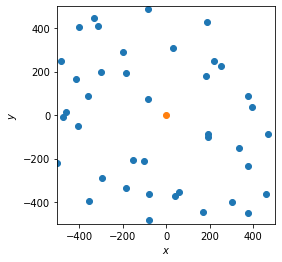

In [4]:
# 基地局の位置
plt.axes().set_aspect('equal',adjustable='box')
plt.xlim(-LENGTH/2,LENGTH/2)
plt.ylim(-LENGTH/2,LENGTH/2)
plt.xlabel(r"$x$")
plt.ylabel(r"$y$")
plt.scatter(BS_x,BS_y)
plt.scatter(0,0) # 原点．ユーザ

$ \displaystyle I = \sum_{ x \in \Phi_\mathrm{b} } \lVert x \rVert^{-\alpha} $


In [5]:
# 干渉電力
I = np.sum( (BS_x**2+BS_y**2)**(-ALPHA/2) ) 
print (I)

9.655792777677073e-09


# 2. モンテカルロシミュレーション

In [6]:
LOOP_n = 1000 # 値を変えてecdfを描いてみるとよい
isPPP = False
#isPPP = True # こちらにすると，BSをシステムエリア内に平均BS_n局のPPPにする

In [7]:
interference_list = list()
for i in range (LOOP_n):
  if isPPP == True:
    BS_np = np.random.poisson(BS_n)
  else:
    BS_np = BS_n
  
  # 以下，単一の場合と同じ
  BS_x = np.random.rand(BS_np)*LENGTH-LENGTH/2
  BS_y = np.random.rand(BS_np)*LENGTH-LENGTH/2
  I = np.sum((BS_x**2+BS_y**2)**(-ALPHA/2))
  # 以上，単一の場合と同じ

  interference_list.append(I)

  # 繰り返し数が多い場合に，経過表示
  if (i%10000==0):
    print(i)

print(10*np.log10(np.average(interference_list)))

0
-22.74947715984258


別途説明するように，$M\to\infty$で発散する値なので，この値に何の意味もない

干渉の最大値を1に制約した上で期待値を取る
（もうちょっと簡単に書けないですかね．）

In [8]:
10*np.log10(np.average(np.amin(np.array([interference_list,np.ones_like(interference_list)]),axis=0)))

-29.91900126933968

（厳密にはPPPの場合）BSの密度を$\lambda$とすると<br>
$\displaystyle \mathbb{E}[I] = \lambda \pi + \frac{2\lambda \pi}{\alpha - 2}$

In [9]:
density = BS_n / LENGTH**2
print(10*np.log10(density*math.pi + 2*density*math.pi/(ALPHA-2)))

-35.99760140313923


In [10]:
# ecdfを描くためにソート
interference_list.sort()

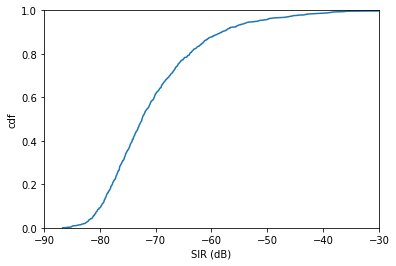

In [11]:
# ecdfを描く
plt.xlim(-90,-30)
plt.ylim(0,1)
plt.xlabel("SIR (dB)")
plt.ylabel("cdf")
plt.plot(10*np.log10(interference_list),np.array(range(LOOP_n))/LOOP_n)

*   バグがないことの確認？
*   繰り返し数は何回？
*   平均値や劣化率？

参考
NumPy, randomで様々な種類の乱数の配列を生成
https://note.nkmk.me/python-numpy-random/

# 3. 確率幾何解析

$ \displaystyle \mathbb{P} ( I \leq x) = \mathrm{erfc} \sqrt{ \pi^3 \lambda^2 / 4x} $

[Haenggi2012, (5.6)]のpdfを積分したもの．講義では導出は説明しない

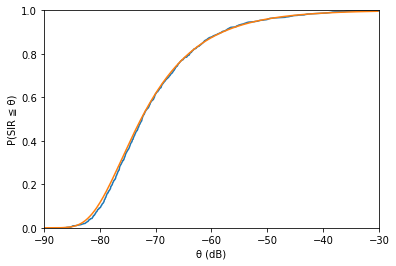

In [12]:

x = np.arange(-90,-30,0.2)
x_lin = 10**(x/10)
#y = 1-1/(1+np.sqrt(x_lin)*np.arctan(np.sqrt(x_lin))) # これが確率幾何解析の結果．他は上と同じ
y = special.erfc(np.sqrt(math.pi**3 * density**2 / (4*x_lin)))
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlim(-90,-30)
ax.set_ylim(0,1)
ax.set_xlabel("θ (dB)") # 手抜きで日本語フォントを使っています
ax.set_ylabel("P(SIR ≦ θ)") # 手抜きで日本語フォントを使っています
ax.plot(10*np.log10(interference_list),np.array(range(LOOP_n))/LOOP_n)
ax.plot(x,y)
plt.show()